In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [10]:
def get_hsv_frame(video_path, frame_num):
    """Get a frame from a video and convert it to HSV and RGB."""
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        raise ValueError("Couldn't retrieve the frame. Check the frame number.")
    return cv2.cvtColor(frame, cv2.COLOR_BGR2HSV), cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

In [11]:
def on_click(event):
    if event.inaxes:
        x, y = int(event.xdata), int(event.ydata)
        pixel_hsv = hsv_frame[y, x]
        print(f"HSV values at ({x}, {y}): {pixel_hsv}")

In [12]:
def inspect_hsv(video_path, frame_num):
    """Display a specific frame for HSV inspection with click events."""
    global hsv_frame, rgb_frame
    hsv_frame, rgb_frame = get_hsv_frame(video_path, frame_num)

    fig, ax = plt.subplots()
    fig.suptitle("Click to display HSV values")
    img = ax.imshow(rgb_frame)
    fig.canvas.mpl_connect('button_press_event', on_click)
    plt.axis('off')
    plt.show()

In [13]:
BALL_COLOR_RANGES = {
    'red1': (np.array([0, 100, 100]), np.array([10, 255, 255])),
    'red2': (np.array([170, 100, 100]), np.array([180, 255, 255])),
    'yellow': (np.array([20, 150, 100]), np.array([30, 255, 255])),
    'green': (np.array([35, 100, 100]), np.array([85, 255, 255])),
    'blue': (np.array([90, 100, 100]), np.array([130, 255, 255])),
    'brown': (np.array([10, 100, 50]), np.array([20, 255, 200])),
    'black': (np.array([0, 0, 0]), np.array([180, 255, 40])),
    'white': (np.array([0, 0, 200]), np.array([180, 25, 255]))
}

In [14]:
def preprocess_image(frame):
    """Enhance contrast and apply Gaussian blur for circle detection."""
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9, 9), 2)
    return blurred


In [15]:
def is_ball_like(hsv_image, center, radius):
    """Check if a detected circle matches any known billiard ball colors."""
    mask = np.zeros(hsv_image.shape[:2], dtype=np.uint8)
    cv2.circle(mask, center, radius, 255, -1)
    masked_hsv = cv2.bitwise_and(hsv_image, hsv_image, mask=mask)

    for _, (lower, upper) in BALL_COLOR_RANGES.items():
        ball_mask = cv2.inRange(masked_hsv, lower, upper)
        color_presence = np.count_nonzero(ball_mask) > (np.pi * (radius ** 2)) * 0.3  # Circle 30% full
        if color_presence:
            return True
    return False

In [16]:
def track_balls(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}.")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        blurred = preprocess_image(frame)

        circles = cv2.HoughCircles(
            blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20,
            param1=70, param2=20, minRadius=3, maxRadius=15
        )

        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        if circles is not None:
            circles = np.uint16(np.around(circles))
            for i in circles[0, :]:
                center = (i[0], i[1])
                radius = i[2]

                if is_ball_like(hsv, center, radius):
                    # Draw the outer circle
                    cv2.circle(frame, center, radius, (0, 255, 0), 2)
                    # Draw the center of the circle
                    cv2.circle(frame, center, 2, (0, 0, 255), 3)

        # Convert BGR (OpenCV) to RGB for matplotlib display
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Plotting the frame
        plt.imshow(frame_rgb)
        plt.axis('off')
        clear_output(wait=True)
        display(plt.gcf())
        plt.pause(0.01)

    cap.release()
    plt.close()

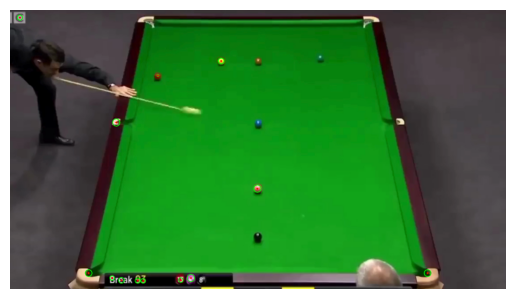

KeyboardInterrupt: 

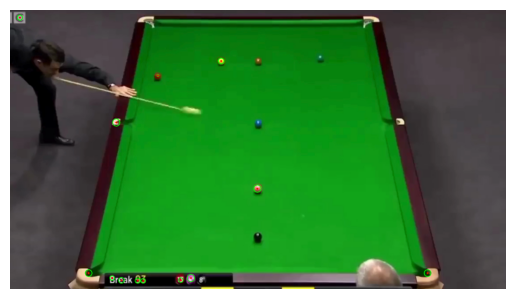

In [17]:
# Function to process all videos in a given folder
def process_videos(folder_path):
    for i in range(1, 17):  # Assuming there are 16 videos
        video_path = f"{folder_path}/{i}.mp4"
        print(f"Processing video: {video_path}")
        track_balls(video_path)

process_videos('dataset')